In [20]:
# Cell 1: Data processing - load masterlist, extract engagement measures

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.core.defchararray import add, split
import helperFunc

# Paths
cwd = Path.cwd()
masterlistpath = cwd / "experiment1freelymoving.csv"
savepath = cwd / "Figure4BC"
savepath.mkdir(exist_ok=True)

# Parameters
proximitythreshold = 10
animals = ['rewarded_male', 'unrewarded_male', 'novel_male', 'female']

# Load masterlist
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

# Unique rat/date instances
separator = '/'
concatenated = add(add(masterlist[:, 0], separator), masterlist[:, 1])
unique_instances = np.unique(concatenated)
uniqueIDs = split(unique_instances, separator)

# Initialize arrays
engagementinfo = np.full((uniqueIDs.shape[0]-2, 4, 3), np.nan)
interdrewarded, interdunrewarded, interdnovel, interdfemale = [], [], [], []
counter = 0

# Loop over rats/dates
for i, instance in enumerate(uniqueIDs):
    rat, date = instance[0], instance[1]

    basepath = cwd / 'NaturalisticSocial' / f"{rat}_{date}" / "Behavior" / f"{rat}_{date}_freelymoving_"
    events = np.loadtxt(cwd / 'NaturalisticSocial' / f"{rat}_{date}" / "Events.csv", delimiter=',', dtype=str)
    firstcontact = events[:, 2].astype(float)

    # Skip problematic days
    if i in [3, 4]:
        continue

    for a, animal in enumerate(animals):
        featurepath = basepath.with_name(basepath.name + animal) / "features.npy"
        try:
            features = np.load(featurepath, allow_pickle=True)
        except:
            print(f"No features for {rat} {date} {animal}")
            continue

        # Median inter-individual distance
        interd = features[29:32, 2:].astype(float)
        medianinterd = np.median(interd, axis=0)

        closeidx = np.where(medianinterd < proximitythreshold)[0]
        sync = features[0, 2:].astype(float)

        if (sync[-1] - sync[0]) < 30:
            print(f"Short recording: {rat} {date} {animal}")
            continue

        contact = firstcontact[a]
        contactidx = np.where(sync > contact)[0][0]
        if (sync[-1] - sync[contactidx]) < 30:
            print(f"Short recording post-contact: {rat} {date} {animal}")
            continue

        contact30sidx = np.where(sync > contact + 30)[0][0]
        contactinterd = medianinterd[contactidx:contact30sidx]

        if a == 0: interdrewarded.extend(contactinterd)
        elif a == 1: interdunrewarded.extend(contactinterd)
        elif a == 2: interdnovel.extend(contactinterd)
        elif a == 3: interdfemale.extend(contactinterd)

        # Bout analysis
        closebouts = sync[helperFunc.extractbouts(closeidx)]
        starttime = closebouts[0, 0]
        closebouts = closebouts - starttime
        closebouts = closebouts[closebouts[:, 0] < 30]
        if closebouts[-1, -1] > 30:
            closebouts[-1, -1] = 30

        closeproximity = np.sum(closebouts[:, -1] - closebouts[:, 0])
        numberofbouts = closebouts.shape[0]

        engagementinfo[counter, a, 0] = closeproximity
        engagementinfo[counter, a, 1] = numberofbouts
        engagementinfo[counter, a, 2] = starttime

    counter += 1

# Convert to numpy arrays
interdrewarded = np.array(interdrewarded)
interdunrewarded = np.array(interdunrewarded)
interdnovel = np.array(interdnovel)
interdfemale = np.array(interdfemale)


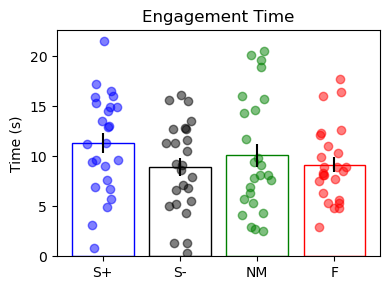

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Condition  1.6481 3.0000 72.0000 0.1859



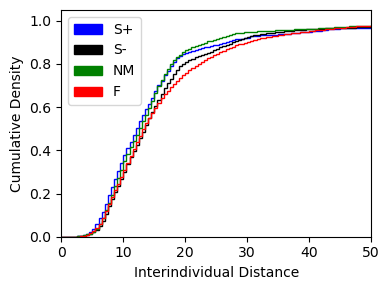

Kruskal-Wallis: H=884.763, p=1.79e-191
Distributions differ (reject H0)
               1              2             3              4
1   1.000000e+00  4.323686e-110  7.541888e-08  1.747792e-131
2  4.323686e-110   1.000000e+00  4.969933e-62   3.180988e-01
3   7.541888e-08   4.969933e-62  1.000000e+00   5.549786e-78
4  1.747792e-131   3.180988e-01  5.549786e-78   1.000000e+00


In [21]:
# Cell 2: Plotting and statistical tests

import matplotlib.patches as mpatches
from scipy import stats
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal
import scikit_posthocs as sp
# -------------------------
# Plot engagement measures
# -------------------------
plt.close()
fig, ax = plt.subplots(1, figsize=(4, 3), sharex='col')
colors = ['blue', 'black', 'green', 'red']
jitter = 0.2

# Engagement time
for a, animal in enumerate(animals):
    ax.bar(a, np.nanmean(engagementinfo[:, a, 0]),
              yerr=stats.sem(engagementinfo[:, a, 0]),
              edgecolor=colors[a], facecolor='none')
    xvals = np.ones(engagementinfo.shape[0]) * a + np.random.uniform(-jitter, jitter, size=engagementinfo.shape[0])
    ax.scatter(xvals, engagementinfo[:, a, 0], color=colors[a], alpha=0.5)


ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['S+', 'S-', 'NM', 'F'])
ax.set_title('Engagement Time')
ax.set_ylabel('Time (s)')

plt.tight_layout()
plt.show()
fig.savefig(savepath / "10cmMeasures.png", format='png')

# -------------------------
# Repeated measures ANOVA
# -------------------------
# Engagement Time
df_time = pd.DataFrame([
    [i, engagementinfo[i, a, 0], animals[a]]
    for i in range(engagementinfo.shape[0])
    for a in range(engagementinfo.shape[1])
], columns=['Subject', 'EngagementTime', 'Condition'])
df_time['Subject'] = df_time['Subject'].astype('category')
anova_time = AnovaRM(df_time, 'EngagementTime', 'Subject', within=['Condition']).fit()
print(anova_time)


# -------------------------
# Cumulative distance histograms
# -------------------------
plt.close()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.hist(interdrewarded, bins=np.arange(0, 100, .5), color='blue', cumulative=True, density=True, histtype='step')
ax.hist(interdunrewarded, bins=np.arange(0, 100, .5), color='k', cumulative=True, density=True, histtype='step')
ax.hist(interdnovel, bins=np.arange(0, 100, .5), color='green', cumulative=True, density=True, histtype='step')
ax.hist(interdfemale, bins=np.arange(0, 100, .5), color='red', cumulative=True, density=True, histtype='step')
ax.set_xlim(0, 50)

legend_patches = [mpatches.Patch(color=c, label=l) for c, l in zip(colors, ['S+', 'S-', 'NM', 'F'])]
ax.legend(handles=legend_patches)
ax.set_xlabel('Interindividual Distance')
ax.set_ylabel('Cumulative Density')

plt.tight_layout()
plt.show()
fig.savefig(savepath / "cumulativedistribution.png", format='png')

# -------------------------
# Nonparametric stats
# -------------------------
stat, p = kruskal(interdrewarded, interdunrewarded, interdnovel, interdfemale)
print(f"Kruskal-Wallis: H={stat:.3f}, p={p:.3g}")
if p < 0.05:
    print("Distributions differ (reject H0)")
else:
    print("No significant difference (fail to reject H0)")

data = [interdrewarded, interdunrewarded, interdnovel, interdfemale]
print(sp.posthoc_dunn(data, p_adjust='bonferroni'))
